In [1]:
import tensorflow as tf
tf.version.VERSION

'2.6.0'

In [2]:
from tensorflow import keras
import numpy as np

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [11]:
import math as m
pi = tf.constant(m.pi)

In [5]:
from keras.models import Model
from keras.layers import Dense, Input, Flatten, MaxPooling3D

In [7]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from keras import layers
import h5py

In [30]:
class Sphere_3d(tf.keras.layers.Layer):
    def sphere(self,x,y,z, x_center, y_center, z_center, radius):
        return -tf.tanh(tf.pow((x_center - x), 2) + tf.pow((y_center - y), 2) + tf.pow((z_center - z), 2) - radius)
 
    def build(self, input_shapes): 
        
        self.x_c = self.add_weight(name='x_c',
        shape=([self.output_channels]), initializer=tf.keras.initializers.RandomUniform(
        minval=-self.ker_size//2, maxval=self.ker_size//2, seed=None
        ),trainable=True)
        
        self.y_c = self.add_weight(name='y_c',
        shape=([self.output_channels]), initializer=tf.keras.initializers.RandomUniform(
        minval=-self.ker_size//2, maxval=self.ker_size//2, seed=None),trainable=True)
        
        self.z_c = self.add_weight(name='z_c',
        shape=([self.output_channels]), initializer=tf.keras.initializers.RandomUniform(
        minval=-self.ker_size//2, maxval=self.ker_size//2, seed=None
        ), trainable=True)
        
        self.R = self.add_weight(name='R',
        shape=([self.output_channels]), initializer=tf.keras.initializers.RandomUniform(
        minval=0, maxval=tf.pow(self.ker_size//2,2), seed=None)
        ,trainable=True)

    def get_weights(self):
        ker_size = self.ker_size
        d1 = []
        for id in range(self.output_channels):
            c1 = self.sphere(self.x,self.y,self.z,self.x_c[id], self.y_c[id], self.z_c[id],self.R[id])
            d1.append(tf.reshape(c1,[ker_size,ker_size,ker_size,1]))
        weights = tf.stack(d1,axis = -1)
        return weights
        
    def __init__(self, ker_size, out_ch,padding = "SAME"):
        super(Sphere_3d, self).__init__()

        self.x = np.array([[np.arange(ker_size)]*ker_size]*ker_size)
        self.y = np.transpose(self.x ,(2,0,1))
        self.z = np.transpose(self.x,(1,2,0))
        self.output_channels = out_ch
        self.padding = padding
        self.ker_size = tf.cast(ker_size, tf.float32)
        self.conv = tf.nn.conv3d
        self.ker_center = (self.ker_size + 1)/2

    def call(self, inputdata):
        return self.conv(inputdata, self.get_weights(),  strides=[1,1, 1, 1, 1], padding = self.padding)

In [18]:
class Tanh3d(tf.keras.layers.Layer):
    def _rotate(self, x, y, theta):
        x_ = x*tf.cos(theta) + y*tf.sin(theta)
        y_ = -x*tf.sin(theta) + y*tf.cos(theta)
        return (x_, y_)

    def _tanh_3d(self, x, y, z, theta, phi, lmbda):
        x, z = self._rotate(x, z, theta) 
        x, y = self._rotate(x, y, phi)
        return tf.tanh(x / lmbda)
    

    def _get_weights(self, theta, phi, lmbda):
        ker_size = self.ker_size
        d1 = []
        for id in range(self.output_channels):
            c1 = self._tanh_3d(self.x,self.y,self.z,theta[id], phi[id], lmbda[id])
            d1.append(tf.reshape(c1,[ker_size,ker_size,ker_size,1]))
        weights = tf.stack(d1,axis = -1)
        return weights

    def _tanh_param_grid(self, theta, phi, lmbda):
        theta_ = []
        phi_ = []
        lmbda_ = []
        for t in theta:
            for p in phi:
                for l in lmbda:
                    theta_.append(t)
                    phi_.append(p)
                    lmbda_.append(l)
        return theta_, phi_, lmbda_

    def build(self, input_shapes): 
        theta_sz = self.output_channels
        lmbda_sz = self.output_channels
        phi_sz = self.output_channels
        
        self.theta = self.add_weight(name='theta',
        shape=((self.output_channels)), initializer='zeros',
                                 trainable=True)
        self.phi = self.add_weight(name='phi',
        shape=((self.output_channels)), initializer='zeros',
                                 trainable=True)
        self.lmbda = self.add_weight(name='lambda',
        shape=((self.output_channels)), initializer='zeros',
                                 trainable=True)
        
        _theta = tf.cast(tf.range(theta_sz),dtype = tf.float32) * (2*pi/theta_sz)
        _phi = tf.cast(tf.range(phi_sz), dtype = tf.float32) * (2*pi/phi_sz)
        _lmbda = tf.exp(tf.cast(tf.range(-lmbda_sz//2+1, lmbda_sz//2+1), dtype = tf.float32))
        
        self.theta.assign(_theta)
        self.phi.assign(_phi)
        self.lmbda.assign(_lmbda)

    def __init__(self, ker_size, out_ch,padding = "SAME"):
        super(Tanh3d, self).__init__()

        self.x = np.array([[np.arange(ker_size)]*ker_size]*ker_size)
        self.y = np.transpose(self.x ,(2,0,1))
        self.z = np.transpose(self.x,(1,2,0))
        self.output_channels = out_ch
        self.padding = padding
        self.ker_size = ker_size
        self.conv = tf.nn.conv3d

    def call(self, input_data):
        self.kernel = self._get_weights(self.theta, self.phi, self.lmbda)
        return self.conv(input_data, self.kernel, strides=[1,1, 1, 1, 1], padding = self.padding)

In [36]:
class Hyper_3d(tf.keras.layers.Layer):
    def hyperboloid_(self,x, y, z,x_c,y_c,z_c, a, b, c):
        return  2*tf.exp(-(((x_c-x)/a)**2 + ((y_c-y)/b)**2 - ((z_c-z)/c)**2 - 1)**2/0.5) - 0.5
    
    def build(self, input_shapes): 
        
        self.x_c = self.add_weight(name='x_c',
        shape=([self.output_channels]), initializer=tf.keras.initializers.RandomUniform(
        minval=-self.ker_size//2, maxval=self.ker_size//2, seed=None
        ),trainable=True)
        
        self.y_c = self.add_weight(name='y_c',
        shape=([self.output_channels]), initializer=tf.keras.initializers.RandomUniform(
        minval=-self.ker_size//2, maxval=self.ker_size//2, seed=None),trainable=True)
        
        self.z_c = self.add_weight(name='z_c',
        shape=([self.output_channels]), initializer=tf.keras.initializers.RandomUniform(
        minval=-self.ker_size//2, maxval=self.ker_size//2, seed=None
        ), trainable=True)
        
        self.a = self.add_weight(name='a',
        shape=([self.output_channels]), initializer=tf.keras.initializers.RandomUniform(
        minval=0, maxval=tf.pow(self.ker_size//2,2), seed=None)
        ,trainable=True)
        
        self.b = self.add_weight(name='b',
        shape=([self.output_channels]), initializer=tf.keras.initializers.RandomUniform(
        minval=0, maxval=tf.pow(self.ker_size//2,2), seed=None)
        ,trainable=True)
        
        self.c = self.add_weight(name='c',
        shape=([self.output_channels]), initializer=tf.keras.initializers.RandomUniform(
        minval=0, maxval=tf.pow(self.ker_size//2,2), seed=None)
        ,trainable=True)

    def get_weights(self):
        ker_size = self.ker_size
        d1 = []
        for id in range(self.output_channels):
            c1 = self.hyperboloid_(self.x,self.y,self.z,self.x_c[id], self.y_c[id], self.z_c[id],self.a[id], self.b[id], self.c[id])
            d1.append(tf.reshape(c1,[ker_size,ker_size,ker_size,1]))
        weights = tf.stack(d1,axis = -1)
        return weights
        
    def __init__(self, ker_size, out_ch,padding = "SAME"):
        super(Hyper_3d, self).__init__()

        self.x = np.array([[np.arange(ker_size)]*ker_size]*ker_size)
        self.y = np.transpose(self.x ,(2,0,1))
        self.z = np.transpose(self.x,(1,2,0))
        self.output_channels = out_ch
        self.padding = padding
        self.ker_size = tf.cast(ker_size, tf.float32)
        self.conv = tf.nn.conv3d
        self.ker_center = (self.ker_size + 1)/2

    def call(self, inputdata):
        return self.conv(inputdata, self.get_weights(),  strides=[1,1, 1, 1, 1], padding = self.padding)

In [37]:
class HyperL_3d(tf.keras.layers.Layer):
    def hyperboloid_(self,x, y, z, a, b, c):
        return  2*tf.exp(-((x/a)**2 + (y/b)**2 - (z/c)**2 - 1)**2/0.5) - 0.5
    
    def build(self, input_shapes): 
        
        self.a = self.add_weight(name='a',
        shape=([self.output_channels]), initializer=tf.keras.initializers.RandomUniform(
        minval=0, maxval=tf.pow(self.ker_size//2,2), seed=None)
        ,trainable=True)
        
        self.b = self.add_weight(name='b',
        shape=([self.output_channels]), initializer=tf.keras.initializers.RandomUniform(
        minval=0, maxval=tf.pow(self.ker_size//2,2), seed=None)
        ,trainable=True)
        
        self.c = self.add_weight(name='c',
        shape=([self.output_channels]), initializer=tf.keras.initializers.RandomUniform(
        minval=0, maxval=tf.pow(self.ker_size//2,2), seed=None)
        ,trainable=True)

    def get_weights(self):
        ker_size = self.ker_size
        d1 = []
        for id in range(self.output_channels):
            c1 = self.hyperboloid_(self.x,self.y,self.z,self.a[id], self.b[id], self.c[id])
            d1.append(tf.reshape(c1,[ker_size,ker_size,ker_size,1]))
        weights = tf.stack(d1,axis = -1)
        return weights
        
    def __init__(self, ker_size, out_ch,padding = "SAME"):
        super(HyperL_3d, self).__init__()

        self.x = np.array([[np.arange(ker_size)]*ker_size]*ker_size)
        self.y = np.transpose(self.x ,(2,0,1))
        self.z = np.transpose(self.x,(1,2,0))
        self.output_channels = out_ch
        self.padding = padding
        self.ker_size = tf.cast(ker_size, tf.float32)
        self.conv = tf.nn.conv3d
        self.ker_center = (self.ker_size + 1)/2

    def call(self, inputdata):
        return self.conv(inputdata, self.get_weights(),  strides=[1,1, 1, 1, 1], padding = self.padding)

In [9]:
x = tf.random.uniform([5,10,10,10,1])

In [12]:
Tanh3d(3,64)(x).shape

TensorShape([5, 10, 10, 10, 64])

In [13]:
from google.colab import files
files.upload()

Saving full_dataset_vectors.h5 to full_dataset_vectors.h5


In [14]:
with h5py.File("full_dataset_vectors.h5", "r") as hf:    
    X_train = hf["X_train"][:]
    y_train = hf["y_train"][:]    
    X_test = hf["X_test"][:]  
    y_test = hf["y_test"][:]  

In [15]:
def one_hot(labels):
    res = []
    for i in labels:
        a = [0]*10
        a[i] = 1
        res.append(a)
    return np.array(res)

In [16]:
train_images = X_train.reshape(10000,16,16,16,1)
train_labels = one_hot(y_train)
val_images = X_test.reshape(2000,16,16,16,1)
val_labels = one_hot(y_test)

In [60]:
inp = Input((16,16,16,1))
#out1 = MyLayerD(2,5,1,8, tf.nn.relu)(inp)
out0 = tf.keras.layers.BatchNormalization()(inp)
#out1 = tf.keras.layers.Conv3D(32,(3,3,3),padding="same", activation = "relu")(out0)
#out1 = Conv3dGabor(5,1,32)(out0)
out1 = Hyper_3d(5,24)(out0)
out12 = Tanh3d(5,24)(out0)
out13 = tf.keras.layers.Conv3D(24,(5,5,5),padding="same", activation = "relu")(out0)
#out2 = Poli3d(3,5,1,32,tf.nn.relu)(out0)
#out2 = tf.keras.layers.Conv3D(32,(5,5,5),padding="same", activation = "relu")(out0)
out3 = MaxPooling3D(pool_size=(2, 2, 2))(tf.concat([out1,out12,out13],axis = 4))
#out3 = MaxPooling3D(pool_size=(2, 2, 2))(out1)
out30 = tf.keras.layers.BatchNormalization()(out3)
out4 = tf.keras.layers.Conv3D(64,(3,3,3),padding="same", activation = "relu")(out30)
#out5 = tf.keras.layers.Conv2D(64,(3,3),padding="valid", activation = "relu")(out4)
#out2 = tf.keras.layers.Conv2D(32,(5,5),padding="valid", activation = "relu")(out1)
out31 = MaxPooling3D(pool_size=(2, 2, 2))(out4)
#out41 = tf.keras.layers.Conv2D(64,(3,3),padding="same", activation = "relu")(out6)
#out51 = tf.keras.layers.Conv2D(128,(3,3),padding="same", activation = "relu")(out41)
#out61 = MaxPooling2D(pool_size=(2, 2))(out51)
out7 = Flatten()(out31)
out70 = tf.keras.layers.BatchNormalization()(out7)
out71 = tf.keras.layers.Dropout(.3)(out70)
out8 = Dense(512,activation = 'relu')(out71)
out80 = tf.keras.layers.Dropout(.3)(out8)
out9 = Dense(128, activation = 'relu')(out80)
out10 = Dense(10,activation = "softmax")(out9)
#outf = F(out)
model = Model(inputs = inp, outputs = out10)

In [49]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 16, 16, 16, 1)]   0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 16, 16, 16, 1)     4         
_________________________________________________________________
hyper_l_3d (HyperL_3d)       (None, 16, 16, 16, 64)    192       
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 8, 8, 8, 64)       0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 8, 8, 8, 64)       256       
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 8, 8, 8, 64)       110656    
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 4, 4, 4, 64)       0   

In [61]:
INIT_LR = 0.0014
BATCH_SIZE = 16
EPOCHS = 50

model.compile(
    loss='categorical_crossentropy', 
    optimizer=keras.optimizers.Adamax(lr=INIT_LR),  
    metrics=['accuracy']  
)
def lr_scheduler(epoch):
    return INIT_LR * 0.96** epoch

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
historyHB = model.fit(
    train_images, train_labels,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(val_images, val_labels),
    callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler)],
    shuffle=True,
    verbose=0,
)

In [23]:
historyTB = model.fit(
    train_images, train_labels,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(val_images, val_labels),
    callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler)],
    shuffle=True,
    verbose=0,
)

In [ ]:
historyH = model.fit(
    train_images, train_labels,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(val_images, val_labels),
    callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler)],
    shuffle=True,
    verbose=0,
)

In [ ]:
history3 = model.fit(
    train_images, train_labels,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(val_images, val_labels),
    callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler)],
    shuffle=True,
    verbose=0,
)

In [ ]:
np.max(historyT3.history['val_accuracy'])

In [ ]:
np.max(historyTB.history['val_accuracy'])

In [ ]:
np.max(historyH.history['val_accuracy'])

In [ ]:
np.max(historyHB.history['val_accuracy'])

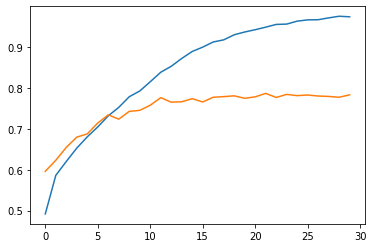

In [25]:
plt.plot(historyTB.history['accuracy']) #5x5 base + tan 
plt.plot(historyTB.history['val_accuracy'])

In [26]:
np.max(historyTB.history['val_accuracy'])

0.7864999771118164

In [51]:
historyHL = model.fit(
    train_images, train_labels,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(val_images, val_labels),
    callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler)],
    shuffle=True,
    verbose=0,
)

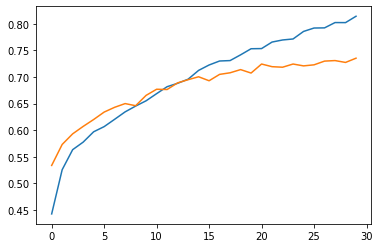

In [34]:
plt.plot(historyS.history['accuracy']) #5x5 Sphere
plt.plot(historyS.history['val_accuracy'])

In [35]:
np.max(historyS.history['val_accuracy'])

0.7354999780654907

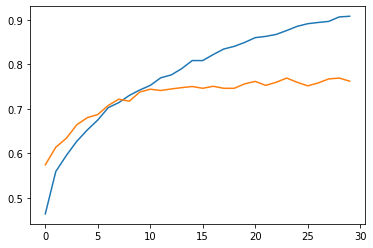

In [46]:
plt.plot(historyH.history['accuracy']) #5x5 Hyper
plt.plot(historyH.history['val_accuracy'])

In [47]:
np.max(historyH.history['val_accuracy'])

0.7689999938011169

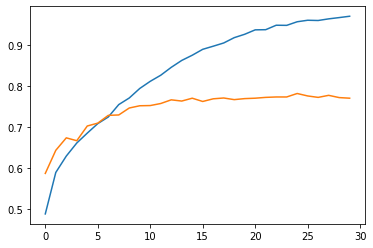

In [55]:
plt.plot(historyHB.history['accuracy']) #5x5 Hyper
plt.plot(historyHB.history['val_accuracy'])

In [56]:
np.max(historyHB.history['val_accuracy'])

0.7820000052452087

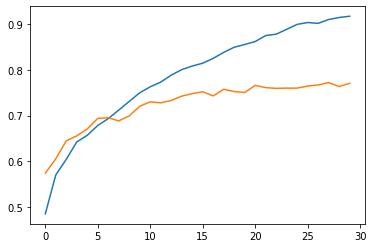

In [57]:
plt.plot(historyHL.history['accuracy']) #5x5 Hyper
plt.plot(historyHL.history['val_accuracy'])

In [59]:
np.max(historyHL.history['val_accuracy'])

0.7720000147819519